In [1]:
import feature_extraction as fe

import numpy as np

import os
import random
import pickle
import warnings
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 3
random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
def data_batcher(data, batch_size):
    random.shuffle(data)
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

In [3]:
dataset = 'GTZAN'
new_feats = False

dataset_filename = f'../datasets/{dataset}.gui'
pickle_filename = f'./feats_spects-pickles/{dataset_filename.split("/")[-1][:-4]}_feats.pkl'
if new_feats or not os.path.isfile(pickle_filename):
    feats, labels = fe.extract_numfeats(dataset_filename)
    with open(pickle_filename, 'wb') as f:
        pickle.dump([feats, labels], f)
else:
    with open(pickle_filename, 'rb') as f:
        feats, labels = pickle.load(f)
    print(f'{feats.shape[0]} features extracted')

1000 features extracted


In [4]:
scaler = StandardScaler()
scaled_feats = scaler.fit_transform(feats)

x_trainval, x_test, y_trainval, y_test = train_test_split(scaled_feats, labels, test_size=1/10) # NO TOCAR!
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=1/9)        # NO TOCAR!

train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
test_data = [(x, y) for x, y in zip(x_test, y_test)]

print(len(train_data), "training samples")
print(len(val_data), "validation samples")
print(len(test_data), "test samples")

800 training samples
100 validation samples
100 test samples


In [5]:
# Fully connected neural network with one hidden layer
class DNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DNNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = nn.Linear(hidden_size[2], hidden_size[3])
        self.fc5 = nn.Linear(hidden_size[3], num_classes)
        
        self.bn2 = nn.BatchNorm1d(hidden_size[1])
        self.bn3 = nn.BatchNorm1d(hidden_size[2])
        self.bn4 = nn.BatchNorm1d(hidden_size[3])
        
        self.drop_layer = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop_layer(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop_layer(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.drop_layer(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x # we can return here the softmax, but then we should use the nll_loss instead of the cross_entropy

In [6]:
def train(log_interval, model, device, data_batches, optimizer, epoch):
    losses = []
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.train()
    
    for i, batch in enumerate(data_batches):
        x, y = list(zip(*batch))
        
        # Move tensors to the configured device
        data = torch.from_numpy(np.array(x)).float().to(device)
        target = torch.from_numpy(np.array(y)).to(device)
        
        # clear all the gradients of the optimized tensors
        optimizer.zero_grad()
    
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (i+1) % log_interval == 0:
            print(f'Train Epoch: {epoch+1} [{str((i+1)*len(data)).zfill((len(str(len_glob_data))))}/{len_glob_data} ({str(int(100. * (i+1)*len(data) / len_glob_data)).zfill(2)}%)]\tLoss: {round(loss.item(),6)}')
    return np.array(losses).mean()

In [7]:
def validate(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = []
    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            validation_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss = np.array(validation_loss).mean()
    accuracy = 100. * correct / len_glob_data

    print(f'\nValidation set: Average loss: {round(validation_loss, 4)}, Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy, validation_loss

In [8]:
def test(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len_glob_data

    print(f'Test set: Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy

In [9]:
# Hyperparameters

input_size = 25
hidden_size = [256, 128, 64, 32]
num_classes = 10

train_batch_size = 5 # NO TOCAR!
valid_batch_size = 100

num_epochs = 600
learning_rate = 0.0001

In [11]:
train_data_batches = data_batcher(train_data, train_batch_size)
val_data_batches = data_batcher(val_data, valid_batch_size)

model = DNNClassifier(input_size, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []
accuracies = []

for epoch in range(num_epochs):
    
    train_loss = train(50, model, device, train_data_batches, optimizer, epoch)
    train_losses.append(train_loss)

    accuracy, valid_loss = validate(model, device, val_data_batches)
    valid_losses.append(valid_loss)
    accuracies.append(accuracy)

Train Epoch: 1 [250/800 (31%)]	Loss: 2.501593
Train Epoch: 1 [500/800 (62%)]	Loss: 2.242944
Train Epoch: 1 [750/800 (93%)]	Loss: 2.467072

Validation set: Average loss: 2.2888, Accuracy: 14/100 (14%)

Train Epoch: 2 [250/800 (31%)]	Loss: 2.232938
Train Epoch: 2 [500/800 (62%)]	Loss: 2.127772
Train Epoch: 2 [750/800 (93%)]	Loss: 2.256931

Validation set: Average loss: 2.2798, Accuracy: 9/100 (9%)

Train Epoch: 3 [250/800 (31%)]	Loss: 2.353354
Train Epoch: 3 [500/800 (62%)]	Loss: 2.124125
Train Epoch: 3 [750/800 (93%)]	Loss: 2.32544

Validation set: Average loss: 2.2681, Accuracy: 17/100 (17%)

Train Epoch: 4 [250/800 (31%)]	Loss: 2.4028
Train Epoch: 4 [500/800 (62%)]	Loss: 2.155384
Train Epoch: 4 [750/800 (93%)]	Loss: 2.211848

Validation set: Average loss: 2.2678, Accuracy: 17/100 (17%)

Train Epoch: 5 [250/800 (31%)]	Loss: 2.375713
Train Epoch: 5 [500/800 (62%)]	Loss: 2.177024
Train Epoch: 5 [750/800 (93%)]	Loss: 2.167406

Validation set: Average loss: 2.2557, Accuracy: 16/100 (16%)



Train Epoch: 41 [750/800 (93%)]	Loss: 1.913304

Validation set: Average loss: 1.7881, Accuracy: 36/100 (36%)

Train Epoch: 42 [250/800 (31%)]	Loss: 2.154264
Train Epoch: 42 [500/800 (62%)]	Loss: 2.433791
Train Epoch: 42 [750/800 (93%)]	Loss: 1.731274

Validation set: Average loss: 1.7422, Accuracy: 37/100 (37%)

Train Epoch: 43 [250/800 (31%)]	Loss: 1.801929
Train Epoch: 43 [500/800 (62%)]	Loss: 2.310313
Train Epoch: 43 [750/800 (93%)]	Loss: 1.593274

Validation set: Average loss: 1.7442, Accuracy: 36/100 (36%)

Train Epoch: 44 [250/800 (31%)]	Loss: 2.207109
Train Epoch: 44 [500/800 (62%)]	Loss: 2.286605
Train Epoch: 44 [750/800 (93%)]	Loss: 1.601827

Validation set: Average loss: 1.7331, Accuracy: 35/100 (35%)

Train Epoch: 45 [250/800 (31%)]	Loss: 1.860677
Train Epoch: 45 [500/800 (62%)]	Loss: 2.331521
Train Epoch: 45 [750/800 (93%)]	Loss: 1.81697

Validation set: Average loss: 1.7134, Accuracy: 37/100 (37%)

Train Epoch: 46 [250/800 (31%)]	Loss: 1.976665
Train Epoch: 46 [500/800 (62

Train Epoch: 82 [250/800 (31%)]	Loss: 1.435801
Train Epoch: 82 [500/800 (62%)]	Loss: 2.105376
Train Epoch: 82 [750/800 (93%)]	Loss: 1.26597

Validation set: Average loss: 1.5495, Accuracy: 41/100 (41%)

Train Epoch: 83 [250/800 (31%)]	Loss: 1.889851
Train Epoch: 83 [500/800 (62%)]	Loss: 2.375962
Train Epoch: 83 [750/800 (93%)]	Loss: 1.238378

Validation set: Average loss: 1.5097, Accuracy: 47/100 (47%)

Train Epoch: 84 [250/800 (31%)]	Loss: 1.357037
Train Epoch: 84 [500/800 (62%)]	Loss: 2.228978
Train Epoch: 84 [750/800 (93%)]	Loss: 1.584054

Validation set: Average loss: 1.5029, Accuracy: 46/100 (46%)

Train Epoch: 85 [250/800 (31%)]	Loss: 2.281409
Train Epoch: 85 [500/800 (62%)]	Loss: 2.229251
Train Epoch: 85 [750/800 (93%)]	Loss: 1.333698

Validation set: Average loss: 1.5009, Accuracy: 48/100 (48%)

Train Epoch: 86 [250/800 (31%)]	Loss: 1.517518
Train Epoch: 86 [500/800 (62%)]	Loss: 2.393555
Train Epoch: 86 [750/800 (93%)]	Loss: 1.472832

Validation set: Average loss: 1.533, Accura

Train Epoch: 122 [250/800 (31%)]	Loss: 1.425381
Train Epoch: 122 [500/800 (62%)]	Loss: 2.710964
Train Epoch: 122 [750/800 (93%)]	Loss: 1.42696

Validation set: Average loss: 1.4076, Accuracy: 46/100 (46%)

Train Epoch: 123 [250/800 (31%)]	Loss: 1.346265
Train Epoch: 123 [500/800 (62%)]	Loss: 2.309138
Train Epoch: 123 [750/800 (93%)]	Loss: 1.756286

Validation set: Average loss: 1.3816, Accuracy: 50/100 (50%)

Train Epoch: 124 [250/800 (31%)]	Loss: 1.835435
Train Epoch: 124 [500/800 (62%)]	Loss: 2.238137
Train Epoch: 124 [750/800 (93%)]	Loss: 1.271928

Validation set: Average loss: 1.3669, Accuracy: 50/100 (50%)

Train Epoch: 125 [250/800 (31%)]	Loss: 1.173509
Train Epoch: 125 [500/800 (62%)]	Loss: 2.264576
Train Epoch: 125 [750/800 (93%)]	Loss: 1.141934

Validation set: Average loss: 1.403, Accuracy: 50/100 (50%)

Train Epoch: 126 [250/800 (31%)]	Loss: 1.455331
Train Epoch: 126 [500/800 (62%)]	Loss: 2.824144
Train Epoch: 126 [750/800 (93%)]	Loss: 1.521159

Validation set: Average loss:

Train Epoch: 162 [250/800 (31%)]	Loss: 1.492446
Train Epoch: 162 [500/800 (62%)]	Loss: 2.567065
Train Epoch: 162 [750/800 (93%)]	Loss: 1.275648

Validation set: Average loss: 1.2926, Accuracy: 51/100 (51%)

Train Epoch: 163 [250/800 (31%)]	Loss: 1.386502
Train Epoch: 163 [500/800 (62%)]	Loss: 1.974144
Train Epoch: 163 [750/800 (93%)]	Loss: 1.474926

Validation set: Average loss: 1.3048, Accuracy: 52/100 (52%)

Train Epoch: 164 [250/800 (31%)]	Loss: 1.052194
Train Epoch: 164 [500/800 (62%)]	Loss: 1.793217
Train Epoch: 164 [750/800 (93%)]	Loss: 1.345168

Validation set: Average loss: 1.3042, Accuracy: 53/100 (53%)

Train Epoch: 165 [250/800 (31%)]	Loss: 1.407993
Train Epoch: 165 [500/800 (62%)]	Loss: 1.870041
Train Epoch: 165 [750/800 (93%)]	Loss: 1.433684

Validation set: Average loss: 1.2788, Accuracy: 50/100 (50%)

Train Epoch: 166 [250/800 (31%)]	Loss: 1.784843
Train Epoch: 166 [500/800 (62%)]	Loss: 2.07555
Train Epoch: 166 [750/800 (93%)]	Loss: 0.994058

Validation set: Average loss

Train Epoch: 202 [250/800 (31%)]	Loss: 1.355965
Train Epoch: 202 [500/800 (62%)]	Loss: 2.234633
Train Epoch: 202 [750/800 (93%)]	Loss: 1.110506

Validation set: Average loss: 1.2366, Accuracy: 58/100 (58%)

Train Epoch: 203 [250/800 (31%)]	Loss: 1.222712
Train Epoch: 203 [500/800 (62%)]	Loss: 1.72799
Train Epoch: 203 [750/800 (93%)]	Loss: 1.305696

Validation set: Average loss: 1.2302, Accuracy: 56/100 (56%)

Train Epoch: 204 [250/800 (31%)]	Loss: 0.924377
Train Epoch: 204 [500/800 (62%)]	Loss: 1.794997
Train Epoch: 204 [750/800 (93%)]	Loss: 1.536813

Validation set: Average loss: 1.2272, Accuracy: 59/100 (59%)

Train Epoch: 205 [250/800 (31%)]	Loss: 0.945159
Train Epoch: 205 [500/800 (62%)]	Loss: 1.833828
Train Epoch: 205 [750/800 (93%)]	Loss: 1.425579

Validation set: Average loss: 1.2214, Accuracy: 61/100 (61%)

Train Epoch: 206 [250/800 (31%)]	Loss: 1.115942
Train Epoch: 206 [500/800 (62%)]	Loss: 2.567853
Train Epoch: 206 [750/800 (93%)]	Loss: 1.386136

Validation set: Average loss

Train Epoch: 242 [250/800 (31%)]	Loss: 1.093433
Train Epoch: 242 [500/800 (62%)]	Loss: 1.535499
Train Epoch: 242 [750/800 (93%)]	Loss: 1.394109

Validation set: Average loss: 1.1786, Accuracy: 62/100 (62%)

Train Epoch: 243 [250/800 (31%)]	Loss: 1.10482
Train Epoch: 243 [500/800 (62%)]	Loss: 1.602496
Train Epoch: 243 [750/800 (93%)]	Loss: 1.260855

Validation set: Average loss: 1.169, Accuracy: 58/100 (58%)

Train Epoch: 244 [250/800 (31%)]	Loss: 1.692583
Train Epoch: 244 [500/800 (62%)]	Loss: 1.944051
Train Epoch: 244 [750/800 (93%)]	Loss: 1.761925

Validation set: Average loss: 1.211, Accuracy: 60/100 (60%)

Train Epoch: 245 [250/800 (31%)]	Loss: 1.279258
Train Epoch: 245 [500/800 (62%)]	Loss: 1.683582
Train Epoch: 245 [750/800 (93%)]	Loss: 1.134765

Validation set: Average loss: 1.166, Accuracy: 60/100 (60%)

Train Epoch: 246 [250/800 (31%)]	Loss: 0.739393
Train Epoch: 246 [500/800 (62%)]	Loss: 2.508854
Train Epoch: 246 [750/800 (93%)]	Loss: 1.042991

Validation set: Average loss: 1

Train Epoch: 282 [250/800 (31%)]	Loss: 0.972912
Train Epoch: 282 [500/800 (62%)]	Loss: 2.091756
Train Epoch: 282 [750/800 (93%)]	Loss: 1.594855

Validation set: Average loss: 1.1442, Accuracy: 61/100 (61%)

Train Epoch: 283 [250/800 (31%)]	Loss: 1.015797
Train Epoch: 283 [500/800 (62%)]	Loss: 1.356428
Train Epoch: 283 [750/800 (93%)]	Loss: 1.768291

Validation set: Average loss: 1.1081, Accuracy: 59/100 (59%)

Train Epoch: 284 [250/800 (31%)]	Loss: 0.778732
Train Epoch: 284 [500/800 (62%)]	Loss: 1.413915
Train Epoch: 284 [750/800 (93%)]	Loss: 1.163017

Validation set: Average loss: 1.1299, Accuracy: 59/100 (59%)

Train Epoch: 285 [250/800 (31%)]	Loss: 0.866358
Train Epoch: 285 [500/800 (62%)]	Loss: 1.841649
Train Epoch: 285 [750/800 (93%)]	Loss: 1.004383

Validation set: Average loss: 1.1527, Accuracy: 62/100 (62%)

Train Epoch: 286 [250/800 (31%)]	Loss: 1.112134
Train Epoch: 286 [500/800 (62%)]	Loss: 1.376461
Train Epoch: 286 [750/800 (93%)]	Loss: 1.234056

Validation set: Average los

Train Epoch: 322 [250/800 (31%)]	Loss: 0.707366
Train Epoch: 322 [500/800 (62%)]	Loss: 1.102862
Train Epoch: 322 [750/800 (93%)]	Loss: 1.131198

Validation set: Average loss: 1.134, Accuracy: 63/100 (63%)

Train Epoch: 323 [250/800 (31%)]	Loss: 1.03646
Train Epoch: 323 [500/800 (62%)]	Loss: 1.191732
Train Epoch: 323 [750/800 (93%)]	Loss: 0.91665

Validation set: Average loss: 1.129, Accuracy: 61/100 (61%)

Train Epoch: 324 [250/800 (31%)]	Loss: 0.943363
Train Epoch: 324 [500/800 (62%)]	Loss: 1.551151
Train Epoch: 324 [750/800 (93%)]	Loss: 1.75561

Validation set: Average loss: 1.0891, Accuracy: 65/100 (65%)

Train Epoch: 325 [250/800 (31%)]	Loss: 0.707764
Train Epoch: 325 [500/800 (62%)]	Loss: 1.367839
Train Epoch: 325 [750/800 (93%)]	Loss: 1.427135

Validation set: Average loss: 1.1304, Accuracy: 64/100 (64%)

Train Epoch: 326 [250/800 (31%)]	Loss: 0.477174
Train Epoch: 326 [500/800 (62%)]	Loss: 0.936818
Train Epoch: 326 [750/800 (93%)]	Loss: 1.750219

Validation set: Average loss: 1.

Train Epoch: 362 [250/800 (31%)]	Loss: 0.798916
Train Epoch: 362 [500/800 (62%)]	Loss: 1.11983
Train Epoch: 362 [750/800 (93%)]	Loss: 0.87339

Validation set: Average loss: 1.1276, Accuracy: 62/100 (62%)

Train Epoch: 363 [250/800 (31%)]	Loss: 0.627477
Train Epoch: 363 [500/800 (62%)]	Loss: 0.928805
Train Epoch: 363 [750/800 (93%)]	Loss: 0.807187

Validation set: Average loss: 1.1296, Accuracy: 58/100 (58%)

Train Epoch: 364 [250/800 (31%)]	Loss: 0.925711
Train Epoch: 364 [500/800 (62%)]	Loss: 1.108927
Train Epoch: 364 [750/800 (93%)]	Loss: 1.632017

Validation set: Average loss: 1.1215, Accuracy: 62/100 (62%)

Train Epoch: 365 [250/800 (31%)]	Loss: 0.672031
Train Epoch: 365 [500/800 (62%)]	Loss: 1.372413
Train Epoch: 365 [750/800 (93%)]	Loss: 0.945256

Validation set: Average loss: 1.1065, Accuracy: 61/100 (61%)

Train Epoch: 366 [250/800 (31%)]	Loss: 0.62778
Train Epoch: 366 [500/800 (62%)]	Loss: 1.533064
Train Epoch: 366 [750/800 (93%)]	Loss: 1.26916

Validation set: Average loss: 1

Train Epoch: 402 [250/800 (31%)]	Loss: 0.463785
Train Epoch: 402 [500/800 (62%)]	Loss: 0.6544
Train Epoch: 402 [750/800 (93%)]	Loss: 1.192769

Validation set: Average loss: 1.0726, Accuracy: 64/100 (64%)

Train Epoch: 403 [250/800 (31%)]	Loss: 1.102602
Train Epoch: 403 [500/800 (62%)]	Loss: 1.64778
Train Epoch: 403 [750/800 (93%)]	Loss: 1.246555

Validation set: Average loss: 1.1138, Accuracy: 60/100 (60%)

Train Epoch: 404 [250/800 (31%)]	Loss: 0.689077
Train Epoch: 404 [500/800 (62%)]	Loss: 1.222706
Train Epoch: 404 [750/800 (93%)]	Loss: 0.889205

Validation set: Average loss: 1.0573, Accuracy: 62/100 (62%)

Train Epoch: 405 [250/800 (31%)]	Loss: 0.631004
Train Epoch: 405 [500/800 (62%)]	Loss: 1.348231
Train Epoch: 405 [750/800 (93%)]	Loss: 0.658533

Validation set: Average loss: 1.0507, Accuracy: 65/100 (65%)

Train Epoch: 406 [250/800 (31%)]	Loss: 0.686299
Train Epoch: 406 [500/800 (62%)]	Loss: 1.374718
Train Epoch: 406 [750/800 (93%)]	Loss: 0.938919

Validation set: Average loss: 

Train Epoch: 442 [250/800 (31%)]	Loss: 1.17669
Train Epoch: 442 [500/800 (62%)]	Loss: 0.981439
Train Epoch: 442 [750/800 (93%)]	Loss: 0.918518

Validation set: Average loss: 1.0397, Accuracy: 66/100 (66%)

Train Epoch: 443 [250/800 (31%)]	Loss: 0.889017
Train Epoch: 443 [500/800 (62%)]	Loss: 0.959346
Train Epoch: 443 [750/800 (93%)]	Loss: 1.26136

Validation set: Average loss: 1.0777, Accuracy: 62/100 (62%)

Train Epoch: 444 [250/800 (31%)]	Loss: 0.582222
Train Epoch: 444 [500/800 (62%)]	Loss: 1.201723
Train Epoch: 444 [750/800 (93%)]	Loss: 0.870752

Validation set: Average loss: 1.0668, Accuracy: 62/100 (62%)

Train Epoch: 445 [250/800 (31%)]	Loss: 0.629492
Train Epoch: 445 [500/800 (62%)]	Loss: 0.916586
Train Epoch: 445 [750/800 (93%)]	Loss: 1.100669

Validation set: Average loss: 1.0606, Accuracy: 63/100 (63%)

Train Epoch: 446 [250/800 (31%)]	Loss: 0.495772
Train Epoch: 446 [500/800 (62%)]	Loss: 1.274603
Train Epoch: 446 [750/800 (93%)]	Loss: 1.068565

Validation set: Average loss:

Train Epoch: 482 [250/800 (31%)]	Loss: 0.505879
Train Epoch: 482 [500/800 (62%)]	Loss: 0.952051
Train Epoch: 482 [750/800 (93%)]	Loss: 1.448197

Validation set: Average loss: 1.0749, Accuracy: 61/100 (61%)

Train Epoch: 483 [250/800 (31%)]	Loss: 0.631042
Train Epoch: 483 [500/800 (62%)]	Loss: 0.671467
Train Epoch: 483 [750/800 (93%)]	Loss: 2.250537

Validation set: Average loss: 1.0885, Accuracy: 60/100 (60%)

Train Epoch: 484 [250/800 (31%)]	Loss: 0.609031
Train Epoch: 484 [500/800 (62%)]	Loss: 0.644729
Train Epoch: 484 [750/800 (93%)]	Loss: 0.696509

Validation set: Average loss: 1.1096, Accuracy: 63/100 (63%)

Train Epoch: 485 [250/800 (31%)]	Loss: 1.055669
Train Epoch: 485 [500/800 (62%)]	Loss: 1.094182
Train Epoch: 485 [750/800 (93%)]	Loss: 0.654877

Validation set: Average loss: 1.0492, Accuracy: 61/100 (61%)

Train Epoch: 486 [250/800 (31%)]	Loss: 0.438201
Train Epoch: 486 [500/800 (62%)]	Loss: 1.231042
Train Epoch: 486 [750/800 (93%)]	Loss: 0.881997

Validation set: Average los

Train Epoch: 522 [250/800 (31%)]	Loss: 0.464216
Train Epoch: 522 [500/800 (62%)]	Loss: 1.055302
Train Epoch: 522 [750/800 (93%)]	Loss: 0.584032

Validation set: Average loss: 1.0563, Accuracy: 65/100 (65%)

Train Epoch: 523 [250/800 (31%)]	Loss: 0.99008
Train Epoch: 523 [500/800 (62%)]	Loss: 1.044966
Train Epoch: 523 [750/800 (93%)]	Loss: 0.725832

Validation set: Average loss: 1.0717, Accuracy: 63/100 (63%)

Train Epoch: 524 [250/800 (31%)]	Loss: 0.789294
Train Epoch: 524 [500/800 (62%)]	Loss: 1.345524
Train Epoch: 524 [750/800 (93%)]	Loss: 1.182676

Validation set: Average loss: 1.0436, Accuracy: 63/100 (63%)

Train Epoch: 525 [250/800 (31%)]	Loss: 0.503979
Train Epoch: 525 [500/800 (62%)]	Loss: 0.945254
Train Epoch: 525 [750/800 (93%)]	Loss: 0.87574

Validation set: Average loss: 1.0542, Accuracy: 66/100 (66%)

Train Epoch: 526 [250/800 (31%)]	Loss: 0.700143
Train Epoch: 526 [500/800 (62%)]	Loss: 0.699618
Train Epoch: 526 [750/800 (93%)]	Loss: 0.4988

Validation set: Average loss: 1

Train Epoch: 562 [250/800 (31%)]	Loss: 0.182123
Train Epoch: 562 [500/800 (62%)]	Loss: 0.785851
Train Epoch: 562 [750/800 (93%)]	Loss: 0.889613

Validation set: Average loss: 1.0703, Accuracy: 65/100 (65%)

Train Epoch: 563 [250/800 (31%)]	Loss: 0.521641
Train Epoch: 563 [500/800 (62%)]	Loss: 1.521684
Train Epoch: 563 [750/800 (93%)]	Loss: 0.729108

Validation set: Average loss: 1.0745, Accuracy: 64/100 (64%)

Train Epoch: 564 [250/800 (31%)]	Loss: 0.612561
Train Epoch: 564 [500/800 (62%)]	Loss: 1.120585
Train Epoch: 564 [750/800 (93%)]	Loss: 1.516505

Validation set: Average loss: 1.0586, Accuracy: 63/100 (63%)

Train Epoch: 565 [250/800 (31%)]	Loss: 2.191414
Train Epoch: 565 [500/800 (62%)]	Loss: 1.063532
Train Epoch: 565 [750/800 (93%)]	Loss: 0.941337

Validation set: Average loss: 1.05, Accuracy: 64/100 (64%)

Train Epoch: 566 [250/800 (31%)]	Loss: 1.648293
Train Epoch: 566 [500/800 (62%)]	Loss: 1.217023
Train Epoch: 566 [750/800 (93%)]	Loss: 0.667511

Validation set: Average loss:

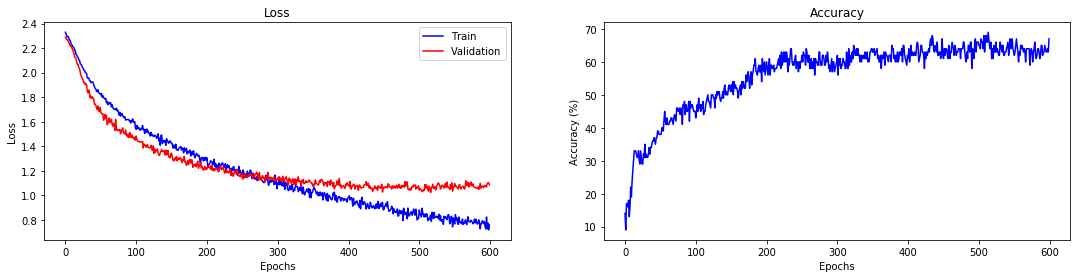

In [12]:
fig = plt.figure()
fig.subplots_adjust(right=2.5)

ax1 = fig.add_subplot(121)
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(train_losses, 'b-', label='Train')
ax1.plot(valid_losses, 'r-', label='Validation')
ax1.legend(loc='upper right')

ax1 = fig.add_subplot(122)
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.plot(accuracies, 'b-')

plt.show()

In [ ]:
#torch.save(model.state_dict(), './results/mgc_dnn_d_bn_fma.model')

In [13]:
test_data_batches = data_batcher(test_data, valid_batch_size)
accuracy = test(model, device, test_data_batches)

Test set: Accuracy: 64/100 (64%)

